In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
import random

# Data preprocessing

In [2]:
data_path = "../data/experiment1-3d"

In [3]:
def merge_csv_files(data_path):
    dfs = []
    raw_data_path = os.path.join(data_path, "raw")
    for file in os.listdir(raw_data_path):
        file_path = os.path.join(raw_data_path, file)
        if file_path.endswith(".txt"):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep="\t"))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join(data_path, "raw_data_merged.csv"), index=False, sep="\t")

merge_csv_files(data_path=data_path)

../data/experiment1-3d\raw\200_1_2022_02_02_16_22_fixed.txt
../data/experiment1-3d\raw\200_1_2022_02_02_16_40.txt
../data/experiment1-3d\raw\200_2_2022_02_04_11_34.txt
../data/experiment1-3d\raw\200_2_2022_02_04_12_03.txt
../data/experiment1-3d\raw\295_1_2022_02_07_17_20.txt
../data/experiment1-3d\raw\295_2_2022_02_08_13_37.txt
../data/experiment1-3d\raw\390_1_2022_01_26_10_34.txt
../data/experiment1-3d\raw\390_2_2022_01_27_13_06.txt
../data/experiment1-3d\raw\450_1_2022_01_10_17_16.txt
../data/experiment1-3d\raw\450_1_2022_01_10_17_47.txt
../data/experiment1-3d\raw\450_2_2022_01_11_14_47.txt
../data/experiment1-3d\raw\542_1_2022_02_03_17_40.txt
../data/experiment1-3d\raw\542_1_2022_02_03_18_02.txt
../data/experiment1-3d\raw\542_2_2022_02_04_17_05.txt
../data/experiment1-3d\raw\543_1_2022_01_10_18_44.txt
../data/experiment1-3d\raw\543_2_2022_01_11_16_01.txt
../data/experiment1-3d\raw\746_1_2022_02_11_13_07.txt
../data/experiment1-3d\raw\746_1_2022_02_11_13_30.txt
../data/experiment1-3d

In [106]:
def plot_traj(traj, traj_id):
    # idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    # idx_response = int(traj.iloc[0].idx_response)
    # idx_min_distance = int(traj.iloc[0].idx_min_distance)
    idx_bot_spawn = 0
    idx_truck_moving = traj.truck_v.to_numpy().nonzero()[0][0]
    idx_bot_moving = traj.bot_v.to_numpy().nonzero()[0][0]
    # idx_bot_visible = traj.truck_.to_numpy().nonzero()[0][0]
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)

    fig, axes = plt.subplots(5, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t[idx_truck_moving:], traj.ego_v[idx_truck_moving:], color="C0")
    axes[0].plot(traj.t[idx_truck_moving], traj.ego_v[idx_truck_moving], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_bot_moving], traj.ego_v[idx_bot_moving], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t[idx_truck_moving:], traj.throttle[idx_truck_moving:], color="C1")
    axes[1].plot(traj.t[idx_truck_moving], traj.throttle[idx_truck_moving], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_bot_moving], traj.throttle[idx_bot_moving], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[idx_truck_moving:], traj.d_ego_bot[idx_truck_moving:], color="C2")
    axes[2].plot(traj.t[idx_truck_moving], traj.d_ego_bot[idx_truck_moving], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_bot_moving], traj.d_ego_bot[idx_bot_moving], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[idx_truck_moving:], traj.tta[idx_truck_moving:], color="C3")
    axes[3].plot(traj.t[idx_truck_moving], traj.tta[idx_truck_moving], color="C7", ls="", marker="o",
                 label="Oncoming car appears")
    axes[3].plot(traj.t[idx_bot_moving], traj.tta[idx_bot_moving], color="C7", ls="", marker="x",
                 label="Decision is made")
    axes[3].set_ylabel("tta")
    # axes[3].set_ylim((0, 7))

    axes[4].plot(traj.t[idx_truck_moving:], traj.bot_v[idx_truck_moving:], color="C6")
    axes[4].plot(traj.t[idx_bot_moving], traj.bot_v[idx_bot_moving], ls="", marker="x", color="C7")
    axes[4].set_ylabel("bot v")
    #
    # axes[5].plot(traj.t[idx_truck_moving:], traj.truck_angle[idx_truck_moving:], color="C4", label="Ego-truck angle")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.bot_angle[idx_truck_moving:], color="C5", label="Ego-bot angle")
    # axes[5].legend()
    # axes[5].set_ylim((-0.1, 0.1))

    axes[-1].set_xlabel("time $t$")

    # legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9),
    #                     title="TTA=%.1fs, d=%im" % (tta, d))
    # legend.get_title().set_fontsize("18")
    plt.tight_layout()

    return fig, axes

In [11]:
data_file="../data/experiment1-3d/raw_data_merged.csv"
data = pd.read_csv(data_file, sep="\t", index_col=["subj_id", "session", "route", "intersection_no"])

In [27]:
data.columns

Index(['intersection_x', 'intersection_y', 'turn_direction', 't',
       'ego_distance_to_intersection', 'tta_condition', 'd_condition',
       'v_condition', 'truck_angle', 'bot_angle', 'accl_profile_values',
       'accl_profile_times', 'ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax',
       'ego_ay', 'ego_yaw', 'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax',
       'bot_ay', 'bot_yaw', 'throttle', 'brake', 'steer', 'let_pass',
       'subjective_good', 'subjective_bad', 'truck_x', 'truck_y', 'truck_vx',
       'truck_vy', 'truck_ax', 'truck_ay', 'truck_yaw', 'ego_v', 'd_ego_bot',
       'bot_v', 'tta'],
      dtype='object')

In [56]:
data = data[abs(data.ego_distance_to_intersection)<20]
data = data[data.turn_direction==1]
data = data[data.d_condition==80]

data["d_ego_bot"] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)
data["ego_v"] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
data["bot_v"] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)
data["truck_v"] = np.sqrt(data.truck_vx**2 + data.truck_vy**2)
data["tta"] = data.d_ego_bot/data.bot_v
data["angle_diff"] = data.truck_angle - data.bot_angle

(543, 2, 10, 16)


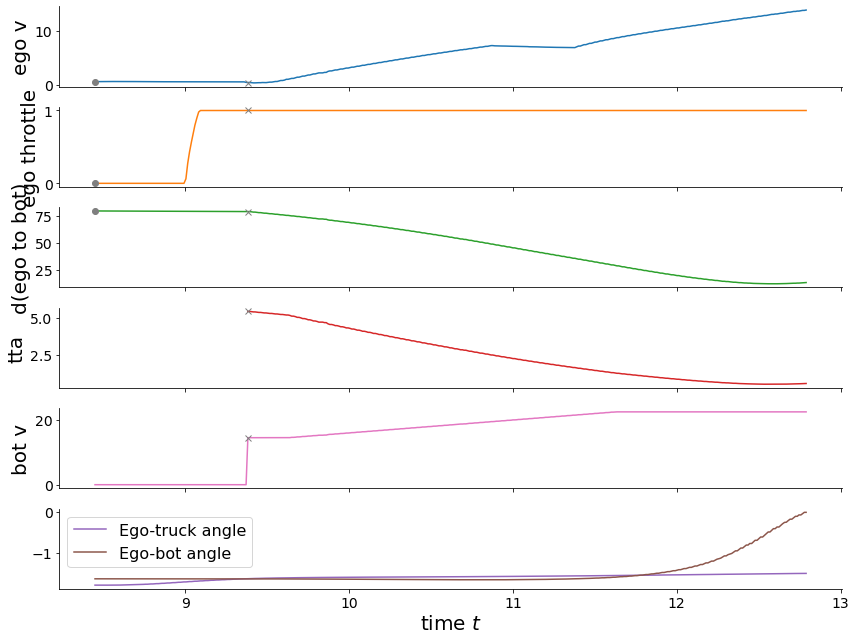

In [105]:
# normal trajectory
# traj_id = (200, 1, 1, 4)

traj_id = random.choice(measures[(measures.RT==0) & (measures.is_go_decision)].index)
print(traj_id)
traj = data.loc[traj_id].reset_index()
plot_traj(traj, traj_id);

In [92]:
def get_measures(traj):
    print(traj.name)
    if (sum(traj.bot_v)>0) & (sum(traj.throttle)>0):
        # the bot started moving when the truck moved far enough not to block the participants" line of sight to the bot
        # so we can count on the first moment the bot velocity is non-zero as the moment the bot became visible first
        # this is what we take as the decision start time
        # idx_truck_moving = traj.truck_v.to_numpy().nonzero()[0][0]
        idx_bot_visible = traj.bot_v.to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_visible:, traj.columns.get_loc("throttle")]
        idx_response = idx_bot_visible + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t.values[idx_response] - traj.t.values[idx_bot_visible]
        idx_min_distance = idx_bot_visible + np.argmin(traj.d_ego_bot[idx_bot_visible:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_visible:].values)
    else:
        # if the bot did not spawn
        idx_bot_visible = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
        
    is_negative_rating = traj.subjective_bad.any()
    return pd.Series({"idx_bot_visible": idx_bot_visible,
                      "idx_response": idx_response,
                      "idx_min_distance": idx_min_distance,
                      "min_distance": min_distance,
                      "RT": RT,
                      "is_negative_rating": is_negative_rating})

In [93]:
def process_data(data):
    data.loc[:,"t"] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))

    data = data.rename(columns={"accl_profile_values": "a_condition"})

    condition_map = {"[0.0, 0.0, 0.0, 0.0]": "Constant speed",
                 "[0.0, -4, 4, 0.0]": "Deceleration nudge",
                 "[0.0, 4, -4, 0.0]": "Acceleration nudge",
                 "[0.0, -4, -4, 0.0]": "Deceleration",
                 "[0.0, 4, 4, 0.0]": "Acceleration"}
    data["nudge_condition"] = data["a_condition"].map(condition_map)

    # we are only interested in left turns
    data = data[data.turn_direction==1]

    # discarding the filler trials
    data = data[data.d_condition==80]

    # only consider the data recorded within 20 meters of each intersection
    data = data[abs(data.ego_distance_to_intersection)<20]

    # smooth the time series by filtering out the noise using Savitzky-Golay filter
    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ["ego_x", "ego_y", "ego_vx", "ego_vy", "ego_ax", "ego_ay",
                      "bot_x", "bot_y", "bot_vx", "bot_vy", "bot_ax", "bot_ay"]
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    # calculate absolute values of speed and acceleration
    data["ego_v"] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data["bot_v"] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)
    data["ego_a"] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data["bot_a"] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)

    # calculate actual distance between the ego vehicle and the bot, and current tta for each t
    data["d_ego_bot"] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)
    data["tta"] = data.d_ego_bot/data.bot_v

    data["truck_v"] = np.sqrt(data.truck_vx**2 + data.truck_vy**2)
    data["angle_diff"] = data.truck_angle - data.bot_angle

    # get the DVs and helper variables
    measures = data.groupby(data.index.names).apply(get_measures)
    print(measures.groupby(["subj_id", "session", "route"]).size())

    # data = data.join(measures)

    # RT is -1 if a driver didn't stop and the bot did not appear at the intersection; we discard these trials
    print("Number of discarded trials: %i" % (len(measures[measures.RT<=0])))
    print(measures[measures.RT<=0].groupby(["subj_id"]).size())

    # data = data[data.RT>0]
    # measures = measures[measures.RT>0]

    # add the condition information to the measures dataframe for further analysis
    conditions = data.loc[:,["tta_condition", "d_condition", "a_condition", "nudge_condition"]].groupby(data.index.names).first()
    measures = measures.join(conditions)

    return data, measures

In [88]:
raw_data = pd.read_csv(os.path.join(data_path, "raw_data_merged.csv"), sep="\t", index_col=["subj_id", "session", "route", "intersection_no"])

In [94]:
processed_data, measures = process_data(raw_data)

(200, 1, 1, 1)
(200, 1, 1, 4)
(200, 1, 1, 7)
(200, 1, 1, 8)
(200, 1, 1, 9)
(200, 1, 1, 11)
(200, 1, 1, 12)
(200, 1, 1, 16)
(200, 1, 1, 17)
(200, 1, 1, 18)
(200, 1, 1, 20)
(200, 1, 1, 21)
(200, 1, 1, 22)
(200, 1, 1, 23)
(200, 1, 1, 24)
(200, 1, 1, 25)
(200, 1, 1, 26)
(200, 1, 1, 27)
(200, 1, 1, 28)
(200, 1, 1, 30)
(200, 1, 2, 1)
(200, 1, 2, 2)
(200, 1, 2, 3)
(200, 1, 2, 4)
(200, 1, 2, 5)
(200, 1, 2, 7)
(200, 1, 2, 9)
(200, 1, 2, 10)
(200, 1, 2, 11)
(200, 1, 2, 12)
(200, 1, 2, 18)
(200, 1, 2, 19)
(200, 1, 2, 20)
(200, 1, 2, 21)
(200, 1, 2, 22)
(200, 1, 2, 23)
(200, 1, 2, 24)
(200, 1, 2, 27)
(200, 1, 2, 29)
(200, 1, 2, 30)
(200, 1, 3, 1)
(200, 1, 3, 4)
(200, 1, 3, 5)
(200, 1, 3, 6)
(200, 1, 3, 8)
(200, 1, 3, 9)
(200, 1, 3, 10)
(200, 1, 3, 12)
(200, 1, 3, 13)
(200, 1, 3, 14)
(200, 1, 3, 17)
(200, 1, 3, 18)
(200, 1, 3, 19)
(200, 1, 3, 20)
(200, 1, 3, 21)
(200, 1, 3, 22)
(200, 1, 3, 23)
(200, 1, 3, 26)
(200, 1, 3, 27)
(200, 1, 3, 28)
(200, 1, 4, 1)
(200, 1, 4, 2)
(200, 1, 4, 3)
(200, 1, 4, 4

In [104]:
measures[(measures.RT==0) & (measures.is_go_decision)].groupby("subj_id").size()

subj_id
200     63
450      2
542    107
543    168
746    140
774      1
946     29
dtype: int64

In [102]:
measures["is_go_decision"] = measures.min_distance > 5

# In some trials this criterion wouldn't work, because e.g. a subject might hit a post after turning left,
# so that the bot is less than 5m away from the ego car after the turn. We need to check this and fix manually
# measures.loc[(305, 1, 1, 8), ["is_turn_decision"]] = True

# add column "decision" for nicer visualization
measures["decision"] = "Stay"
measures.loc[measures.is_go_decision, ["decision"]] = "Go"
measures["p_go_decision"] = measures.decision == "Go"

# measures.to_csv(os.path.join(data_path, "measures.csv"), index=True)
# data.to_csv(os.path.join(data_path, "processed_data.csv"), index=True)
# measures = measures.reset_index()

In [15]:
len(measures[measures.is_negative_rating])/len(measures)

0.0375

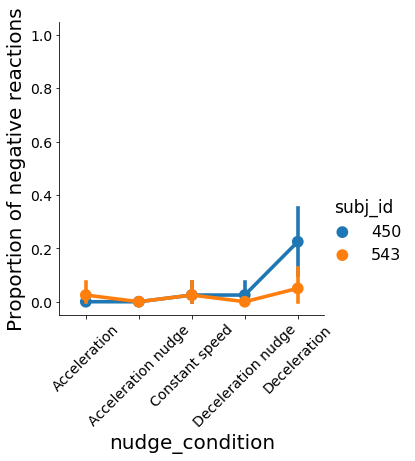

In [22]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point", hue="subj_id",
               order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

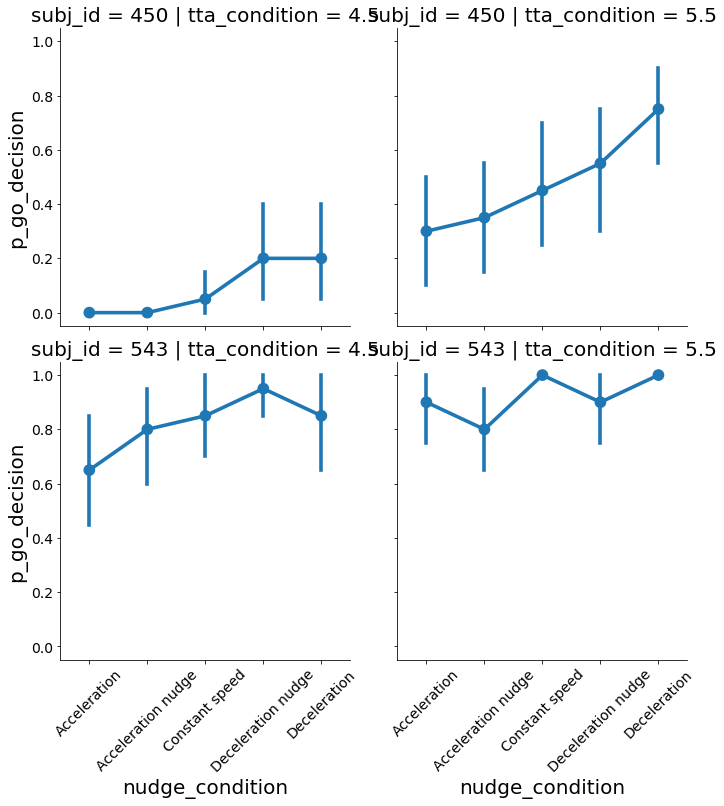

In [13]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision",
                row="subj_id", col="tta_condition", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)